*This is the initial implementation of the problem following meeting 2*

### Extracted Story
~~Several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. Each general observes the enemy and communicates his observation to the others. Each general then combines all the reported observations into a single plan of action (i.e., “attack” or “retreat”), for example, by using a majority vote. Communicating only by messengers, the generals must agree upon a common, and reasonable battle plan, however, one or more of them may be traitors who will try to confuse the others. All loyal generals must carry out the same plan, whereas the traitors may do anything they wish.~~

### Extracted Story (verbatim)
We imagine that several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. The generals can communicate with one another only by messenger. After observing the enemy, they must decide upon a common plan of action. However, some of the generals may be traitors, trying to prevent the loyal generals from reaching agreement.
...
All loyal generals decide upon the same plan of action... but the traitors may do anything they wish.
...
They loyal generals should not only reach agreement, but should agree upon a reasonable plan.

*Everything below this point is based on the verbatim version of the story.*

### User Stories
* As a GENERAL I want to...
  * make observations on an enemy city to decide upon a plan of action.
  * be able to communicate with other genrals to share our observations.
* As a LOYAL GENERAL I want to...
  * decide upon a reasonable plan of action so that my division does what is best.
  * decide upon the same plan of action as all other loyal generals so order within the army is maintained.
* As a DISLOYAL GENERAL I want to...
  * make false or contradicting observations to prevent the loyal generals from reaching agreement.
* As a MESSENGER I want to...
  * deliver messages between generals/divisons so they can reach upon some agreement.

### Assumptions
* There is only one messenger.
* "Enemy" and "Enemy City" are taken to refer to the same idea.
* A "reasonable plan" is assumed to mean that which wins a majority vote.
* The enemy/city is taken to have no functionality other than just "existing".
  * A city is assumed to be objectively either "attackable" or not, i.e., all generals make the same observations on the same city.
* A traitorous general simply "lies" to the other generals, i.e., he communicates the opposite of his observations to all generals.
* The observations that generals can make are either "attack" or "retreat".

### Design Decisions
* Enemy cities are simply instances of a class that essentially does nothing (yet).
* Each general works by first making an "objective" decision on an enemy. This is his true observation and not necessarily the one he communicates to the others.
* There is no tie breaker for the majority vote!

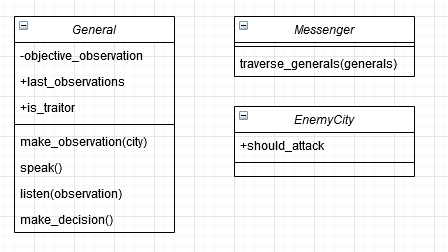

### Interesting Observations
Due to the absence of a tie breaker, in the event of a tie, generals simply return the first observation in their list of observations. This has interesting implications with how the rest of the code is structured in that loyal generals ALWAYS agree on a plan. This plan is not necessarily the "correct" one, but the point is that they never fail to reach agreement!

In [448]:
import random
from itertools import combinations
from collections import Counter, defaultdict

In [449]:
LOG_COMMUNICATIONS = True  # Display the communication network between generals (this can get messy!)
SHOULD_ATTACK = False  # None for random
TOTAL_GENERALS = 30
PERCENTAGE_TRAITORS = 0.67  # -1 for random

In [450]:
class EnemyCity:
    def __init__(self, should_attack):
        self.should_attack = should_attack

In [451]:
class General:
    def __init__(self, is_traitor=False):
        self._objective_observation = None
        self.last_observations = []
        self.is_traitor = is_traitor
    
    def make_observation(self, city: EnemyCity):
        self._objective_observation = ('retreat', 'attack')[city.should_attack]
    
    def speak(self):
        if not self.is_traitor:
            return self._objective_observation
        
        # Traitors lie
        if self._objective_observation == 'attack':
            return 'retreat'
        
        return 'attack'
    
    def listen(self, observation):
        self.last_observations.append(observation)
    
    def make_decision(self):
        return Counter(self.last_observations).most_common(1)[0][0]

In [452]:
class Messenger:
    @staticmethod
    def traverse_generals(generals):
        # {General: {target: message, ...}}
        comms = defaultdict(dict)
        
        for x, y in combinations(generals, 2):
            y_speak = y.speak()
            x_speak = x.speak()
            
            x.listen(y_speak)
            y.listen(x_speak)
            
            comms[y][x] = y_speak
            comms[x][y] = x_speak
        
        return comms

In [453]:
def main():
    if PERCENTAGE_TRAITORS != -1:
        num_traitors = int(TOTAL_GENERALS * PERCENTAGE_TRAITORS)
    else:
        num_traitors = int(TOTAL_GENERALS * random.random())
    
    generals = [General(False) for _ in range(TOTAL_GENERALS - num_traitors)] + \
               [General(True) for _ in range(num_traitors)]
    
    if SHOULD_ATTACK is not None:
        city = EnemyCity(SHOULD_ATTACK)
    else:
        city = EnemyCity(random.choice([True, False]))
    
    print(
        f'Running with {TOTAL_GENERALS} total generals of which'
        f' {num_traitors} are traitorous. EnemyCity.should_attack == {city.should_attack}\n'
    )
    
    # Each general makes an objective observation
    for g in generals:
        g.make_observation(city)
    
    # Each general communicates his observation (or not)
    m = Messenger()
    communications = m.traverse_generals(generals)
    
    # Each general comes up with a plan of action
    loyal_poa = set()
    
    for x, g in enumerate(generals):
        decision = g.make_decision()
        
        if not g.is_traitor:
            loyal_poa.add(decision)
            
#         print(
#             f'General {x} {"(traitor)" if g.is_traitor else "(loyal)":>9}'
#             f' says {decision.upper():>7} based on {g.last_observations:}'
#         )
    
    if len(loyal_poa) != 1:
        print('Loyal Generals cannot agree on a plan of action!!!\n')
    else:
        print(f'Loyal Generals have agreed on: {loyal_poa.pop()}\n')
    
    if LOG_COMMUNICATIONS:
        for x, g in enumerate(communications):
            a, r = 0, 0
            
            for msg in communications[g].values():
                if msg == 'attack':
                    a += 1
                else:
                    r += 1
                    
            print(
                f'{"[!] " if g.is_traitor else ""}'
                f'General {x} has made the objective observation of {g._objective_observation.upper()}'
                f' and reported ATTTACK {a} times and RETREAT {r} times'
            )

In [454]:
if __name__ == '__main__':
    main()

Running with 30 total generals of which 20 are traitorous. EnemyCity.should_attack == False

Loyal Generals have agreed on: attack

General 0 has made the objective observation of RETREAT and reported ATTTACK 0 times and RETREAT 29 times
General 1 has made the objective observation of RETREAT and reported ATTTACK 0 times and RETREAT 29 times
General 2 has made the objective observation of RETREAT and reported ATTTACK 0 times and RETREAT 29 times
General 3 has made the objective observation of RETREAT and reported ATTTACK 0 times and RETREAT 29 times
General 4 has made the objective observation of RETREAT and reported ATTTACK 0 times and RETREAT 29 times
General 5 has made the objective observation of RETREAT and reported ATTTACK 0 times and RETREAT 29 times
General 6 has made the objective observation of RETREAT and reported ATTTACK 0 times and RETREAT 29 times
General 7 has made the objective observation of RETREAT and reported ATTTACK 0 times and RETREAT 29 times
General 8 has made t